<a href="https://colab.research.google.com/github/Kroomer/Master_thesis/blob/main/Master_thesis_3_focal_loss_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connect to drive**  


Click link and enter authorization code

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/Master thesis"

 create_extracted_dataset.R   Lexique-query.csv
 emotion_dict.csv	     'Lexique-query final.csv'
 final_dataset.csv	     'NN-SVG adapted from LeNail (2019).png'
 halflife-regression-master  'unique words.txt'
 learning_traces.13m.csv


# **Connect to GPU**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi

Found GPU at: /device:GPU:0
Wed Jun 23 17:10:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

# **Import libraries**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier

import pydot 
import graphviz
from tensorflow.keras.utils import plot_model

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_auc_score, roc_curve, plot_roc_curve, precision_recall_fscore_support, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import os
import tempfile

# # Fix for random errors
# import six
# import sys
# sys.modules['sklearn.externals.six'] = six
# import sklearn.neighbors._base
# sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import imblearn
from imblearn.pipeline import Pipeline
from collections import Counter

import statistics
from scipy import interp
from scipy.stats import truncnorm

# fix random seed for reproducibility
np.random.seed(14)
tf.random.set_seed(14)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# **Import data**  
Final dataset created using "create_extracted_dataset.R"

Combining data from:
1. Duolingo spaced repetition (1.21 GB)
> B. Settles and B. Meeder. 2016. A Trainable Spaced Repetition Model for Language Learning.
In Proceedings of the Association for Computational Linguistics (ACL), pages 1848-1858.<br/>
> https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/N8XJME
2. SUBTLEX-US data 
>Manually created on http://www.lexique.org/shiny/openlexicon/
3. "Emotion dictionary", created by Geoff Hollis and Chris Westbury based on Warriner, Kuperman and Brysbaert (*2007*)
>Link: http://crr.ugent.be/programs-data,<br/>
>Direct link: https://sites.ualberta.ca/~hollis/files/emotion_dict.csv



In [ ]:
final_dataset = pd.read_csv("drive/My Drive/Colab Notebooks/Master thesis/final_dataset.csv", sep=',')
final_dataset.head()

,p_recall,timestamp,delta,history_seen,history_correct,history_incorrect,dummy_noun,dummy_verb,words,FREQcount,CDcount,Valence,Arousal,Concreteness
0,1,1362082519,3888560,5,5,0,0,1,thank,56877,7790,0.751554,0.377968,0.557784
1,1,1362082532,287,40,37,3,0,0,i,2038529,8372,0.544628,0.371790,0.533944
2,1,1362082532,287,87,80,7,0,0,the,1501908,8388,0.645179,0.330776,0.461627
3,1,1362082532,287,79,70,9,1,0,apple,1207,689,0.646746,0.339613,0.974410
4,1,1362082532,287,64,56,8,1,0,man,94133,8054,0.505728,0.451745,0.916435


In [ ]:
# Don't want the "words" column.
final_dataset.pop('words')
final_dataset.describe()

,p_recall,timestamp,delta,history_seen,history_correct,history_incorrect,dummy_noun,dummy_verb,FREQcount,CDcount,Valence,Arousal,Concreteness
count,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06
mean,8.361450e-01,1.362589e+09,6.862933e+05,3.972093e+01,3.424126e+01,5.479667e+00,4.666492e-01,2.197202e-01,1.600285e+05,4.338620e+03,6.057379e-01,3.775665e-01,6.499140e-01
std,3.701440e-01,2.942436e+05,2.084959e+06,2.311720e+02,1.985168e+02,4.987316e+01,4.988866e-01,4.140571e-01,3.646153e+05,3.257039e+03,6.758736e-02,4.693279e-02,2.153472e-01
min,0.000000e+00,1.362083e+09,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+01,1.400000e+01,1.331056e-01,1.841600e-01,9.250205e-02
25%,1.000000e+00,1.362346e+09,4.690000e+02,4.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.724000e+03,1.022000e+03,5.621335e-01,3.460062e-01,4.692620e-01
50%,1.000000e+00,1.362595e+09,4.183800e+04,8.000000e+00,7.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.033600e+04,3.827000e+03,6.057379e-01,3.760237e-01,6.539603e-01
75%,1.000000e+00,1.362845e+09,3.846388e+05,2.000000e+01,1.800000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.083640e+05,8.254000e+03,6.467458e-01,4.038101e-01,8.294996e-01
max,1.000000e+00,1.363105e+09,3.724681e+07,1.351800e+04,1.288800e+04,2.457000e+03,1.000000e+00,1.000000e+00,2.134713e+06,8.388000e+03,8.936641e-01,6.609906e-01,1.074385e+00


# **Clean data**

In [ ]:
cleaned_df = final_dataset.copy()

# Columns covering a huge range. Convert to log-space.
cleaned_df['log timestamp'] = np.log(cleaned_df.pop('timestamp'))
cleaned_df['log delta'] = np.log(cleaned_df.pop('delta'))
cleaned_df['log history_seen'] = np.log(cleaned_df.pop('history_seen'))
cleaned_df['log history_correct'] = np.log(cleaned_df.pop('history_correct'))
cleaned_df['log FREQcount'] = np.log(cleaned_df.pop('FREQcount'))
cleaned_df['log CDcount'] = np.log(cleaned_df.pop('CDcount'))
cleaned_df['log Valence'] = np.log(cleaned_df.pop('Valence'))
cleaned_df['log Arousal'] = np.log(cleaned_df.pop('Arousal'))
cleaned_df['log Concreteness'] = np.log(cleaned_df.pop('Concreteness'))
cleaned_df.describe()

,p_recall,history_incorrect,dummy_noun,dummy_verb,log timestamp,log delta,log history_seen,log history_correct,log FREQcount,log CDcount,log Valence,log Arousal,log Concreteness
count,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06,3.628934e+06
mean,8.361450e-01,5.479667e+00,4.666492e-01,2.197202e-01,2.103265e+01,9.752850e+00,2.275656e+00,2.160277e+00,9.518371e+00,7.862031e+00,-5.078608e-01,-9.817592e-01,-4.956570e-01
std,3.701440e-01,4.987316e+01,4.988866e-01,4.140571e-01,2.159446e-04,3.559627e+00,1.315525e+00,1.317163e+00,2.492906e+00,1.213273e+00,1.166200e-01,1.248932e-01,3.782716e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.103228e+01,0.000000e+00,0.000000e+00,0.000000e+00,2.944439e+00,2.639057e+00,-2.016613e+00,-1.691950e+00,-2.380524e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.103247e+01,6.150603e+00,1.386294e+00,1.098612e+00,7.452402e+00,6.929517e+00,-5.760160e-01,-1.061299e+00,-7.565941e-01
50%,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.103266e+01,1.064156e+01,2.079442e+00,1.945910e+00,9.243388e+00,8.249836e+00,-5.013079e-01,-9.781031e-01,-4.247086e-01
75%,1.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,2.103284e+01,1.286006e+01,2.995732e+00,2.890372e+00,1.159325e+01,9.018453e+00,-4.358019e-01,-9.068106e-01,-1.869326e-01
max,1.000000e+00,2.457000e+03,1.000000e+00,1.000000e+00,2.103303e+01,1.743308e+01,9.511777e+00,9.464052e+00,1.457384e+01,9.034557e+00,-1.124253e-01,-4.140156e-01,7.174847e-02


**Imbalanced data**  
On target variable "p_recall"

Examples:
	Total:		3628934
	Negative:	594619	(16.39% of total)
	Positive:	3034315	(83.61% of total)



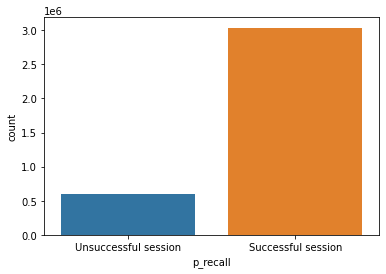

In [ ]:
# Describe target
neg_clean, pos_clean = np.bincount(cleaned_df['p_recall'])
total_clean = neg_clean + pos_clean
print('Examples:\n\tTotal:\t\t{}\n\tNegative:\t{}\t({:.2f}% of total)\n\tPositive:\t{}\t({:.2f}% of total)\n'.format(
    total_clean, neg_clean, 100 * neg_clean / total_clean, pos_clean, 100 * pos_clean / total_clean))
# visualize target
g = sns.countplot(x='p_recall',data=cleaned_df)
g.set_xticklabels(['Unsuccessful session','Successful session'])
plt.show()

# **Create features and labels**

In [ ]:
# Create labels train and test
# .pop already deletes p_recall from data
df = cleaned_df.copy()

y = np.array(df.pop('p_recall'))
x = np.array(df.copy())

# **MLP Plots**  
Visualisation of neural network

In [ ]:
# Reset keras session
K.clear_session()

def make_model():
  model = keras.Sequential([
      # bias = false because batchnorm
      keras.layers.Dense(64, activation='relu', input_shape=(12,), use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(64, activation='relu', use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(64, activation='relu', use_bias=False),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(1, activation='sigmoid'),
  ])
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=.001),
      loss=keras.losses.BinaryCrossentropy(),
      )

  return model

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4096      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4

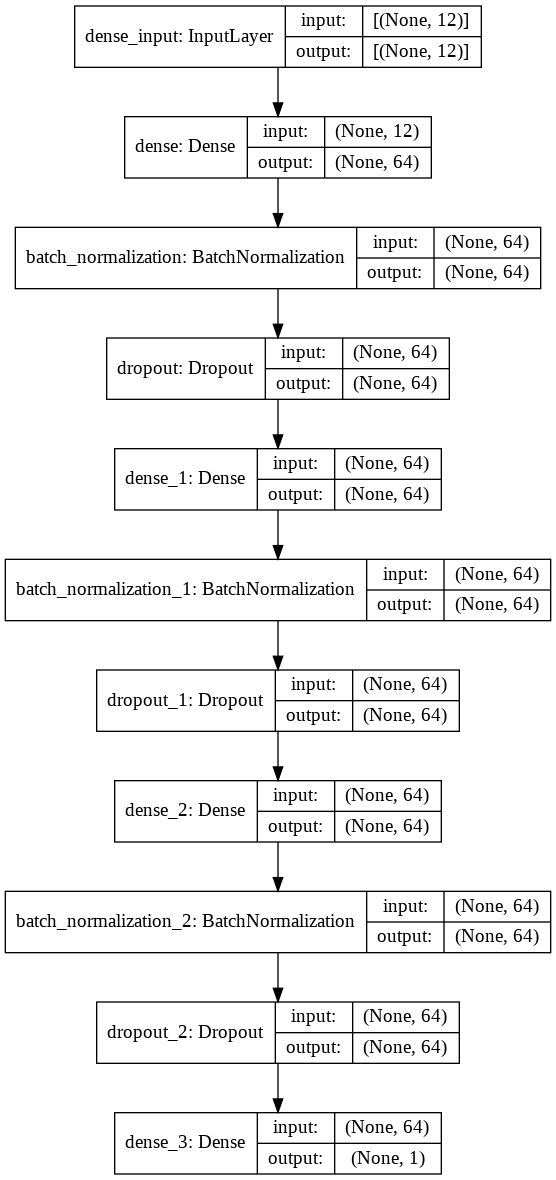

In [ ]:
# Nice visualisation
plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/Results/MLP_plot.png', show_shapes=True, show_layer_names=True)

# **MLP Model**  
3 repeated stratified 5 fold  
Sampler and scaler + reshaping data done manually

Confusion matrix printing in output (to check F1 and specificity)


In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  print('\np_recall 0 correctly predicted (True Negatives):\t', cm[0][0])
  print('p_recall 1 incorrectly predicted (False Positives):\t', cm[0][1])
  print('p_recall 0 incorrectly predicted (False Negatives):\t', cm[1][0])
  print('p_recall 1 correctly predicted (True Positives):\t', cm[1][1])
  print('Total incorrectly predicted p_recall:\t\t\t', cm[1][0]+cm[0][1])

Define focal loss function

In [ ]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss

    return binary_focal_loss_fixed

In [ ]:
# Reset keras session
K.clear_session()

# fix random seed for reproducibility
np.random.seed(14)
tf.random.set_seed(14)

scaler = StandardScaler()
a = 0
b = 0

METRICS = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'),
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.AUC(name='ROC_AUC'),
          keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve as a little extra
    ]

# Max 100 epochs
# Highest batchsize possible (high number of lines)
EPOCHS = 100
BATCH_SIZE = 16384

# Use early stopping, min validation loss, patience: 10 epoch
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=20,
    mode='min',
    restore_best_weights=True)

# k-fold: 5, repeat: 3, random_state to reproduce because comp and time restriction (multiple models)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=14)

Train feats (train + val) dataset: (2903147, 12) 	Test feats: (725787, 12)
Train labels (train + val) dataset: (2903147,) 		Test labels: (725787,)

Train feats sampled dataset: (2177360, 12) 	Val feats: (725787, 12) 	Test feats: (725787, 12)
Train labels sampled dataset: (2177360,) 	Val labels: (725787,) 		Test labels: (725787,)

Train set:
    Total:	2177360
    Negative:	356771	(16.39%)
    Positive:	1820589	(83.61%)

Val set:
    Total:	725787
    Negative:	118924	(16.39%)
    Positive:	606863	(83.61%)

Test set:
    Total:	725787
    Negative:	118924	(16.39%)
    Positive:	606863	(83.61%)


loss :  0.051928550004959106
tp :  546169.0
fp :  89682.0
tn :  29242.0
fn :  60694.0
accuracy :  0.7928097248077393
ROC_AUC :  0.6600784659385681
prc :  0.901549220085144
f1: 0.762144820417686
specificity: 0.24588813023422867 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 29242
p_recall 1 incorrectly predicted (False Positives):	 89682
p_recall 0 incorrectly predicted (False Negatives):	 60694
p_recall 1 correctly predicted (True Positives):	 546169
Total incorrectly predicted p_recall:			 150376

Run: 1 completed


loss :  0.051869191229343414
tp :  545242.0
fp :  89083.0
tn :  29841.0
fn :  61621.0
accuracy :  0.7923578023910522
ROC_AUC :  0.6615224480628967
prc :  0.9022166132926941
f1: 0.7633454422901054
specificity: 0.25092496047875035 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 29841
p_recall 1 incorrectly predicted (False Positives):	 89083
p_recall 0 incorrectly predicted (False Negatives):	 61621
p_recall 1 correctly predicted (True Positives):	 545242
Total incorrectly predicted p_recall:			 150704

Run: 2 completed


loss :  0.05193158984184265
tp :  554033.0
fp :  92195.0
tn :  26729.0
fn :  52830.0
accuracy :  0.8001824021339417
ROC_AUC :  0.6604211926460266
prc :  0.9017165303230286
f1: 0.7624330398381504
specificity: 0.22475698765579297 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 26729
p_recall 1 incorrectly predicted (False Positives):	 92195
p_recall 0 incorrectly predicted (False Negatives):	 52830
p_recall 1 correctly predicted (True Positives):	 554033
Total incorrectly predicted p_recall:			 145025

Run: 3 completed


loss :  0.05192858353257179
tp :  544468.0
fp :  88907.0
tn :  30017.0
fn :  62395.0
accuracy :  0.791533887386322
ROC_AUC :  0.6601530909538269
prc :  0.9012351036071777
f1: 0.762082282157444
specificity: 0.2524048972450873 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 30017
p_recall 1 incorrectly predicted (False Positives):	 88907
p_recall 0 incorrectly predicted (False Negatives):	 62395
p_recall 1 correctly predicted (True Positives):	 544468
Total incorrectly predicted p_recall:			 151302

Run: 4 completed


loss :  0.05187297984957695
tp :  552125.0
fp :  91323.0
tn :  27600.0
fn :  54738.0
accuracy :  0.7987547516822815
ROC_AUC :  0.6617845892906189
prc :  0.9021985530853271
f1: 0.763513471130041
specificity: 0.23208294442603022 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 27600
p_recall 1 incorrectly predicted (False Positives):	 91323
p_recall 0 incorrectly predicted (False Negatives):	 54738
p_recall 1 correctly predicted (True Positives):	 552125
Total incorrectly predicted p_recall:			 146061

Run: 5 completed


loss :  0.05189160257577896
tp :  551042.0
fp :  91166.0
tn :  27758.0
fn :  55821.0
accuracy :  0.7974791526794434
ROC_AUC :  0.6609233021736145
prc :  0.9019702672958374
f1: 0.7628583022783171
specificity: 0.2334095724998878 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 27758
p_recall 1 incorrectly predicted (False Positives):	 91166
p_recall 0 incorrectly predicted (False Negatives):	 55821
p_recall 1 correctly predicted (True Positives):	 551042
Total incorrectly predicted p_recall:			 146987

Run: 6 completed


loss :  0.05193982645869255
tp :  545299.0
fp :  89032.0
tn :  29892.0
fn :  61564.0
accuracy :  0.7925066351890564
ROC_AUC :  0.6600229740142822
prc :  0.9013032913208008
f1: 0.7620199468030417
specificity: 0.251353805791723 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 29892
p_recall 1 incorrectly predicted (False Positives):	 89032
p_recall 0 incorrectly predicted (False Negatives):	 61564
p_recall 1 correctly predicted (True Positives):	 545299
Total incorrectly predicted p_recall:			 150596

Run: 7 completed


loss :  0.05187593400478363
tp :  547543.0
fp :  90323.0
tn :  28601.0
fn :  59320.0
accuracy :  0.7938196659088135
ROC_AUC :  0.6619650721549988
prc :  0.9024547338485718
f1: 0.7637253257931798
specificity: 0.2404981332613766 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 28601
p_recall 1 incorrectly predicted (False Positives):	 90323
p_recall 0 incorrectly predicted (False Negatives):	 59320
p_recall 1 correctly predicted (True Positives):	 547543
Total incorrectly predicted p_recall:			 149643

Run: 8 completed


loss :  0.05192568153142929
tp :  551368.0
fp :  91313.0
tn :  27611.0
fn :  55495.0
accuracy :  0.7977257966995239
ROC_AUC :  0.6599700450897217
prc :  0.9017221927642822
f1: 0.762134333247138
specificity: 0.23217348895073142 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 27611
p_recall 1 incorrectly predicted (False Positives):	 91313
p_recall 0 incorrectly predicted (False Negatives):	 55495
p_recall 1 correctly predicted (True Positives):	 551368
Total incorrectly predicted p_recall:			 146808

Run: 9 completed


loss :  0.051912710070610046
tp :  557862.0
fp :  93364.0
tn :  25559.0
fn :  49001.0
accuracy :  0.8038471341133118
ROC_AUC :  0.6609482169151306
prc :  0.9013996720314026
f1: 0.762670734440283
specificity: 0.21492057886177196 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 25559
p_recall 1 incorrectly predicted (False Positives):	 93364
p_recall 0 incorrectly predicted (False Negatives):	 49001
p_recall 1 correctly predicted (True Positives):	 557862
Total incorrectly predicted p_recall:			 142365

Run: 10 completed


loss :  0.05187779664993286
tp :  552271.0
fp :  91406.0
tn :  27518.0
fn :  54592.0
accuracy :  0.7988418340682983
ROC_AUC :  0.661929190158844
prc :  0.9021469950675964
f1: 0.7635912310280139
specificity: 0.23139147690942838 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 27518
p_recall 1 incorrectly predicted (False Positives):	 91406
p_recall 0 incorrectly predicted (False Negatives):	 54592
p_recall 1 correctly predicted (True Positives):	 552271
Total incorrectly predicted p_recall:			 145998

Run: 11 completed


loss :  0.051909830421209335
tp :  551297.0
fp :  91336.0
tn :  27588.0
fn :  55566.0
accuracy :  0.797596275806427
ROC_AUC :  0.6606432795524597
prc :  0.9020334482192993
f1: 0.7626943243051237
specificity: 0.2319800881233124 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 27588
p_recall 1 incorrectly predicted (False Positives):	 91336
p_recall 0 incorrectly predicted (False Negatives):	 55566
p_recall 1 correctly predicted (True Positives):	 551297
Total incorrectly predicted p_recall:			 146902

Run: 12 completed


loss :  0.05192489176988602
tp :  548368.0
fp :  90189.0
tn :  28735.0
fn :  58495.0
accuracy :  0.7951409816741943
ROC_AUC :  0.6594727635383606
prc :  0.9012249112129211
f1: 0.761625127508329
specificity: 0.2416249032993831 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 28735
p_recall 1 incorrectly predicted (False Positives):	 90189
p_recall 0 incorrectly predicted (False Negatives):	 58495
p_recall 1 correctly predicted (True Positives):	 548368
Total incorrectly predicted p_recall:			 148684

Run: 13 completed


loss :  0.05190299078822136
tp :  549504.0
fp :  90529.0
tn :  28395.0
fn :  57359.0
accuracy :  0.7962377667427063
ROC_AUC :  0.6608858704566956
prc :  0.9017384648323059
f1: 0.762750453575606
specificity: 0.23876593454623224 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 28395
p_recall 1 incorrectly predicted (False Positives):	 90529
p_recall 0 incorrectly predicted (False Negatives):	 57359
p_recall 1 correctly predicted (True Positives):	 549504
Total incorrectly predicted p_recall:			 147888

Run: 14 completed


loss :  0.05190803110599518
tp :  553181.0
fp :  91873.0
tn :  27050.0
fn :  53682.0
accuracy :  0.7994518876075745
ROC_AUC :  0.6608551740646362
prc :  0.9016652703285217
f1: 0.7627038242080895
specificity: 0.22745810314217815 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:137: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



p_recall 0 correctly predicted (True Negatives):	 27050
p_recall 1 incorrectly predicted (False Positives):	 91873
p_recall 0 incorrectly predicted (False Negatives):	 53682
p_recall 1 correctly predicted (True Positives):	 553181
Total incorrectly predicted p_recall:			 145555

Run: 15 completed



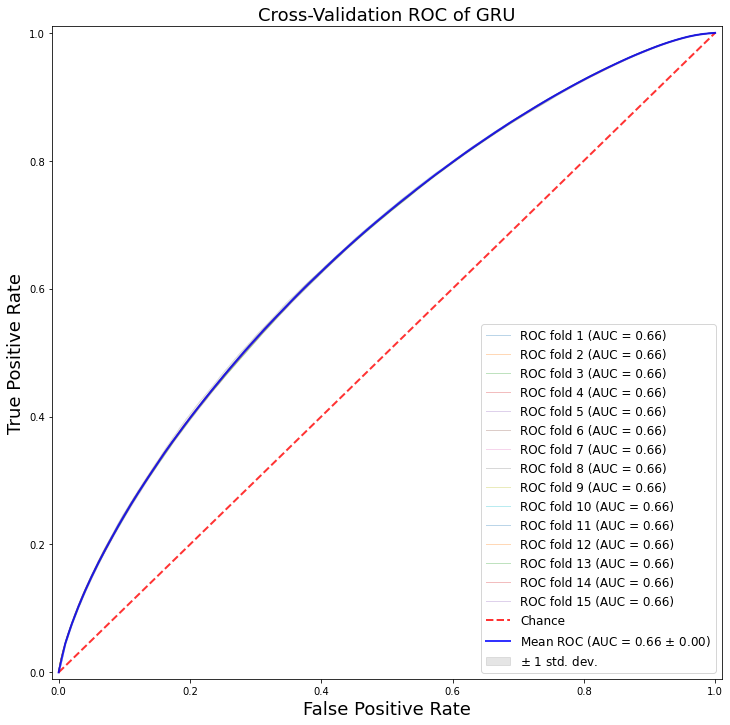

In [ ]:
# Runtime complete 3 repeated 5 fold in seconds:
# 3300 sec

# Manual loop to reshape k fold train data for GRU prediction model
plt.rcParams["figure.figsize"] = (12,12)

accuracy_MLP = []
specificity_MLP = []
ROC_AUC_MLP = []
F1_MLP = []

# ROC AUC plot
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

# Loop through the indices the split() method returns
for index, (train_index, test_index) in enumerate(cv.split(x, y)):
    index = index+1
    
    # Reset keras session
    K.clear_session()

    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Split temp train to train and val set 
    # Train = 0.6
    # Val   = 0.2
    # Test  = 0.2
    train_features, val_features, train_labels, val_labels = train_test_split(
        x_train, y_train, test_size=0.25,random_state=14, stratify = y_train)

    # Sampling method
    # None

    # Check Sampling method
    while a < 1:
      # Print initial split 80% train (train + val), 20% test
      print('Train feats (train + val) dataset:', x_train.shape, '\tTest feats:', x_test.shape)
      print('Train labels (train + val) dataset:', y_train.shape, '\t\tTest labels:', y_test.shape)
      
      print('\nTrain feats sampled dataset:', train_features.shape, '\tVal feats:', val_features.shape, '\tTest feats:', x_test.shape)
      print('Train labels sampled dataset:',  train_labels.shape, '\tVal labels:', val_labels.shape, '\t\tTest labels:', y_test.shape)
      # Check stratify
      neg, pos = np.bincount(train_labels)
      total = neg + pos
      print('\nTrain set:\n    Total:\t{}\n    Negative:\t{}\t({:.2f}%)\n    Positive:\t{}\t({:.2f}%)'.format(
          total, neg, 100 * neg / total, pos, 100 * pos / total))
      neg, pos = np.bincount(val_labels)
      total = neg + pos
      print('\nVal set:\n    Total:\t{}\n    Negative:\t{}\t({:.2f}%)\n    Positive:\t{}\t({:.2f}%)'.format(
          total, neg, 100 * neg / total, pos, 100 * pos / total))
      neg, pos = np.bincount(y_test)
      total = neg + pos
      print('\nTest set:\n    Total:\t{}\n    Negative:\t{}\t({:.2f}%)\n    Positive:\t{}\t({:.2f}%)\n'.format(
          total, neg, 100 * neg / total, pos, 100 * pos / total))
      a = a + 1

    # Normalize using standardscaler
    # Norm to mean 0, standard deviation 1
    # Fit scaler on train data, and use it on val and test to simulate real world scenario and avoid data leakage
    train_features_rus = scaler.fit_transform(train_features)
    val_features_scaled = scaler.transform(val_features)
    test_features_scaled = scaler.transform(x_test)

    # Clear model, and create it
    model = None

    # Dunno if this works but as a proper programmer would say: best leave it... 
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    # Create the model can be outside loop but can't be bothered 
    def make_model(metrics=METRICS):
      model = keras.Sequential([
          # bias = false because batchnorm
          keras.layers.Dense(64, activation='relu', input_shape=(train_features_rus.shape[-1],), use_bias=False),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.1),
          keras.layers.Dense(64, activation='relu', use_bias=False),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.1),
          keras.layers.Dense(64, activation='relu', use_bias=False),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.1),
          keras.layers.Dense(1, activation='sigmoid'),
      ])

      # Compile with new focal loss function
      model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=.001),
          loss=[binary_focal_loss(alpha=.25, gamma=2)],
          metrics=METRICS)
      return model
    
    model = make_model()

    # Fit model on train, use validation set for model fit
    model.fit(train_features_rus,train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS,
              callbacks=[early_stopping],validation_data=(val_features_scaled, val_labels), verbose=0)

    # Predict on test
    test_predictions_baseline = model.predict(test_features_scaled, batch_size=BATCH_SIZE, verbose=0)

    # Evaluate on test
    baseline_results = model.evaluate(test_features_scaled, y_test, batch_size=BATCH_SIZE, verbose=0)

    # Append scores for future evalution
    accuracy_MLP.append(baseline_results[5])
    ROC_AUC_MLP.append(baseline_results[6])    

    print('')
    # Print all scores
    for name, value in zip(model.metrics_names, baseline_results):
      print(name, ': ', value)
    
    # Create and append F1 and specificity score, because only god knows why keras doesn't have it in their metrics
    f1_score = 2 * (baseline_results[6] * baseline_results[7]) / (baseline_results[6] + baseline_results[7])
    print('f1:', f1_score)
    
    # True neg / (true neg + false pos)
    specificity_score = baseline_results[3] / (baseline_results[3] + baseline_results[2] + K.epsilon()) #tn / (tn + fn + epsilon in rare case of 0)
    print('specificity:', specificity_score,'\n')

    F1_MLP.append(f1_score)
    specificity_MLP.append(specificity_score)

    # Add Classifier type to model (keras didn't add it dunno why)
    model._estimator_type = "classifier"
    # ROC AUC plot
    # `model.predict_proba()` is deprecated, but this still works by altering estimator_type :)
    probas_ = model.predict_proba(test_features_scaled)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (index, roc_auc))

    # Future: Create and add averaged cm plot
    # If time available...
    plot_cm(y_test, test_predictions_baseline)

    print('\nRun:', index, 'completed\n')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of GRU',fontsize=18)
plt.legend(loc="lower right", prop={'size': 12})

# Specify ROC_AUC plot for sampling method
plt.savefig('/content/drive/My Drive/Colab Notebooks/Results/FocalLoss_MLP_ROC_AUC_plot.png')
plt.show()

# **Results**

In [ ]:
score = statistics.mean(accuracy_MLP)
min = np.min(accuracy_MLP)
max = np.max(accuracy_MLP)
median = statistics.median(accuracy_MLP)
std = statistics.stdev(accuracy_MLP)
print('MLP 5 fold - 3 repeat results:\n')
print('Mean accuracy:\t', score, '\nMedian:\t\t', median, '\nMin:\t\t', min, '\nMax:\t\t', max, '\nStd.:\t\t', std)
specificity = statistics.mean(specificity_MLP)
ROC_AUC = statistics.mean(ROC_AUC_MLP)
f1 = statistics.mean(F1_MLP)
print('\nF1:\t\t', f1, '\nSpecificity:\t', specificity, '\nROC AUC:\t', ROC_AUC)

MLP 5 fold - 3 repeat results:

Mean accuracy:	 0.7965523799260458 
Median:		 0.7974791526794434 
Min:		 0.791533887386322 
Max:		 0.8038471341133118 
Std.:		 0.0034941710424022275

F1:		 0.7626861772680366 
Specificity:	 0.2366422670283943 
ROC AUC:	 0.6607717116673787


Write and export results to Drive  
.csv files

In [ ]:
df_MLP_rus = pd.DataFrame({'accuracy_MLP' : accuracy_MLP, 'F1_MLP' : F1_MLP,
                           'specificity_MLP' : specificity_MLP, 'ROC_AUC_MLP' : ROC_AUC_MLP})

df_MLP_rus.to_csv('/content/drive/My Drive/Colab Notebooks/Results/results_MLP_FocalLoss.csv', index=False)
df_MLP_rus

,accuracy_MLP,F1_MLP,specificity_MLP,ROC_AUC_MLP
0,0.792810,0.762145,0.245888,0.660078
1,0.792358,0.763345,0.250925,0.661522
2,0.800182,0.762433,0.224757,0.660421
3,0.791534,0.762082,0.252405,0.660153
4,0.798755,0.763513,0.232083,0.661785
5,0.797479,0.762858,0.233410,0.660923
6,0.792507,0.762020,0.251354,0.660023
7,0.793820,0.763725,0.240498,0.661965
8,0.797726,0.762134,0.232173,0.659970
9,0.803847,0.762671,0.214921,0.660948


# **Evaluate one MLP model**

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Results/FocalLoss_MLP_CM_plot.png')

  print('p_recall 0 correctly predicted (True Negatives):\t', cm[0][0])
  print('p_recall 1 incorrectly predicted (False Positives):\t', cm[0][1])
  print('p_recall 0 incorrectly predicted (False Negatives):\t', cm[1][0])
  print('p_recall 1 correctly predicted (True Positives):\t', cm[1][1])

loss :  0.05190803110599518
tp :  553181.0
fp :  91873.0
tn :  27050.0
fn :  53682.0
accuracy :  0.7994518876075745
ROC_AUC :  0.6608551740646362
prc :  0.9016652703285217

p_recall 0 correctly predicted (True Negatives):	 27050
p_recall 1 incorrectly predicted (False Positives):	 91873
p_recall 0 incorrectly predicted (False Negatives):	 53682
p_recall 1 correctly predicted (True Positives):	 553181


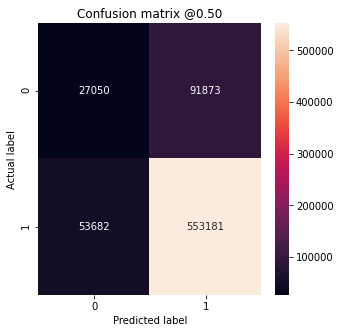

In [ ]:
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

**Show training progress**

In [ ]:
# Clear model, and create it
model = None

# Dunno if this works but as a proper programmer would say: best leave it... 
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Create the model can be outside loop but can't be bothered 
def make_model(metrics=METRICS):
      model = keras.Sequential([
          # bias = false because batchnorm
          keras.layers.Dense(64, activation='relu', input_shape=(train_features_rus.shape[-1],), use_bias=False),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.1),
          keras.layers.Dense(64, activation='relu', use_bias=False),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.1),
          keras.layers.Dense(64, activation='relu', use_bias=False),
          keras.layers.BatchNormalization(),
          keras.layers.Dropout(0.1),
          keras.layers.Dense(1, activation='sigmoid'),
      ])

      # Compile with new focal loss function
      model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=.001),
          loss=[binary_focal_loss(alpha=.25, gamma=2)],
          metrics=METRICS)
      return model
    
model = make_model()

# Fit model on train, use validation set for model fit
history = model.fit(train_features_rus,train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    callbacks=[early_stopping],validation_data=(val_features_scaled, val_labels), verbose=0)

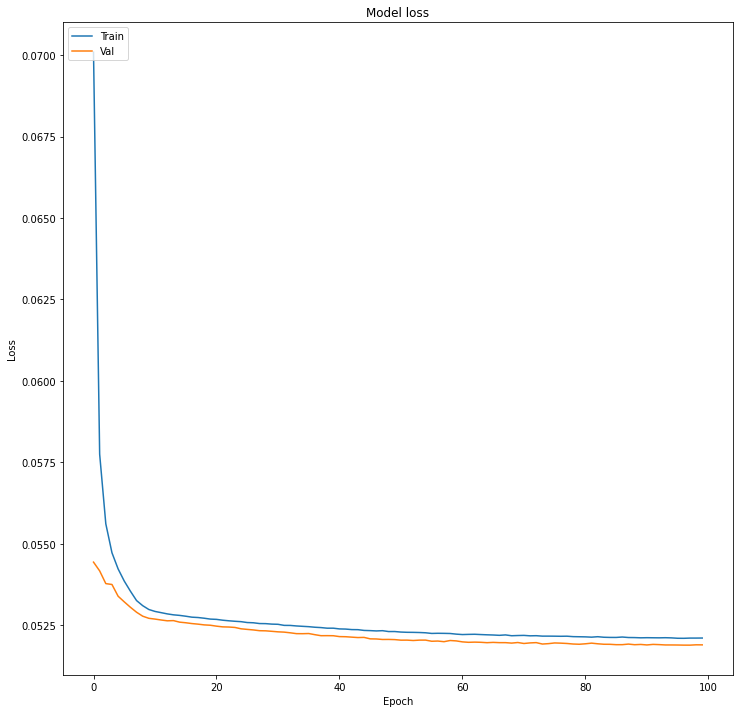

In [ ]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('/content/drive/My Drive/Colab Notebooks/Results/FocalLoss_MLP_loss_plot.png')
plt.show()

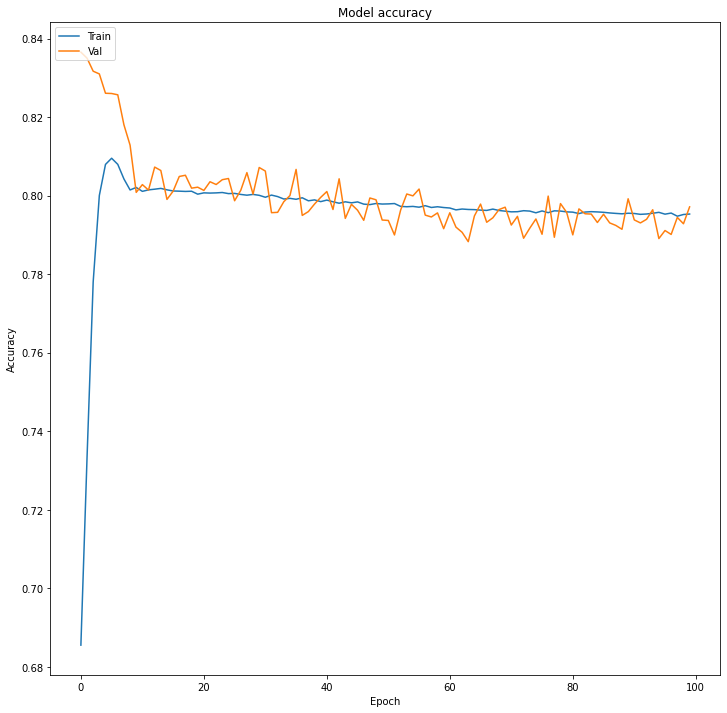

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('/content/drive/My Drive/Colab Notebooks/Results/FocalLoss_MLP_accuracy_plot.png')
plt.show()